# Boston MPO Dasymetric Population Map
To map census demographic data onto conveyal raster outputs, we need to create a gridded version of the census demographic data that will match the grid used in Conveyal analyses.

This process will follow binary dasymetric interpolation as shown here: https://pysal.org/tobler/notebooks/binary_dasymetric.html.

A similar methodology is also used by the EPA, documented here: https://github.com/USEPA/Dasymetric-Toolbox-OpenSource and https://enviroatlas.epa.gov/enviroatlas/DataFactSheets/pdf/Supplemental/DasymetricAllocationofPopulation.pdf. Note EPA toolboxes map population denisty to the landcover file spatial resolution. The process below outputs population density matching the conveyal grid.

To map the census tract level demographic onto the raster grid, we will allocate population density within a tract based on two filters: residential road and land cover classification. This process starts by pulling road centerlines and buffering the shapes. Then, within the road buffer we find the areas that have a land classification of at least 5% of a 30 meter square area as impervious surface. Then, after applying the daymetric filters, we interpolate the area so that the population density within a tract is assigned to the grid cells that match the conveyal outputs.

In [9]:
import geopandas as gpd
import pandas as pd
#import osmnx as ox
#import contextily as ctx
import numpy as np
import matplotlib.pyplot as plt

from tobler.area_weighted import area_interpolate
from tobler.dasymetric import extract_raster_features
from tobler.util import h3fy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Prep streets from the MPO
Streets pulled from OSM, excluding primary roads.
Note, street network pulled in OSMPull notbook.

Future work: Could test if just pulling residential streets in suburban/rural areas is more representative of where pop lives there

In [10]:
# instead of pulling residential streets
# read in steets from osm pull and remove osmid in primary streets
mpo_streets = gpd.read_file("data/mpo_drive_network.gpkg",layer = 'edges')
primary_streets = gpd.read_file("data/MA_drive_primary.gpkg", layer = 'edges')
primary_ids = primary_streets.osmid.unique()
mpo_streets_res = mpo_streets[~mpo_streets.osmid.isin(primary_ids)]


project and buffer streets by 300 ft (91.44 meters)

In [11]:
###### project and buffer streets by 300 ft (91.44 meters)
mpo_streets_res = mpo_streets_res.to_crs(26986)
mpo_streets_res = mpo_streets_res.buffer(91.44)
#mpo_streets_res.info()

## Prep landcover data from NLCD
2019 landcover downloaded from: full landcover (https://www.mrlc.gov/data/nlcd-2019-land-cover-conus) and impervious surfaces (https://www.mrlc.gov/data/nlcd-2019-developed-imperviousness-descriptor-conus), download: https://www.mrlc.gov/data?f%5B0%5D=year%3A2019


This step pulls in landcover with at least 5% impevious surface within the 30 meter square grid cell that overlaps with a buffered street.

In [12]:
nlcd_path = 'data/nlcd_2019_impervious_descriptor_l48_20210604/nlcd_2019_impervious_descriptor_l48_20210604.img'

<AxesSubplot:>

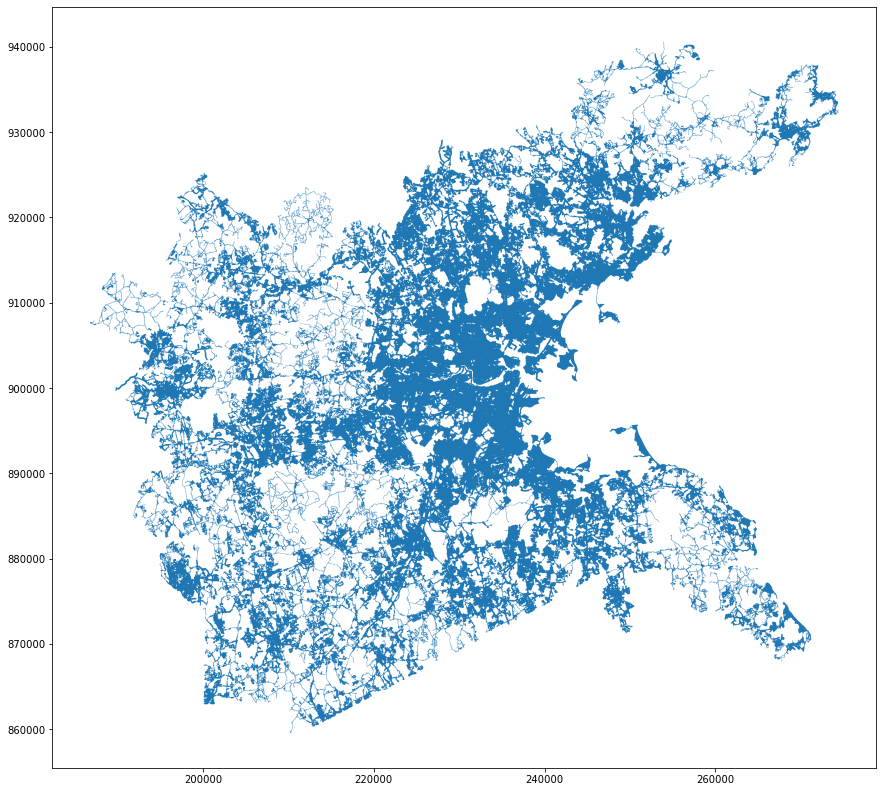

In [13]:
dev_mpo = extract_raster_features(mpo_streets_res, nlcd_path,  pixel_values=list(range(5,101)), collapse_values=True)
#dev_mpo.info()
dev_mpo = dev_mpo.to_crs(26986)

fig, ax = plt.subplots(figsize=(20,14))
dev_mpo.plot(ax=ax)

## Prep census data
tract level census data pulled with tidycensus in demographic data prep analysis scripts.

In [14]:
demo = gpd.read_file('../output/DemographicData.gpkg', layer = 'tracts_acs_dec_2020')
demo = demo.to_crs(26986)

<AxesSubplot:>

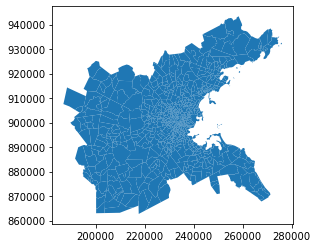

In [15]:
demo.plot()

In [16]:
mpo_grid = gpd.read_file('data/mpo_conveyal_grid_as_vector.gpkg', layer= 'workers')
#mpo_grid = gpd.read_file('data/mpo_conveyal_grid_as_vector.gpkg', layer= 'workers_unclipped')
mpo_grid = mpo_grid.to_crs(26986)
mpo_grid.info()

# if we didn't need to match to conveyal grid, could use hexagons or make own grid
#mpo_hex = h3fy(demo, resolution=8)
#mpo_hex.plot()
#mpo_hex.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 70339 entries, 0 to 70338
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   workers   70339 non-null  float64 
 1   geometry  70339 non-null  geometry
dtypes: float64(1), geometry(1)
memory usage: 1.1 MB


## Set up intersection between developed areas and demographic data

In [17]:
dasy = gpd.clip(demo, dev_mpo)

Review result after clipping. Note there is one GEOID that has not developed area (and no population) that is not in dasy. Also the population matches between decennial and dasy only after you dissolve by GEOID so as not to overcount population.
Note: Unpopulated tract is Census Tract 9901.01, Suffolk County, Massachusetts.

In [18]:
# note one GEOID with no people has no developed area in it.
print('Unique GEOIDs in dasy:', dasy['GEOID'].nunique())
print('Unique GEOIDs in demo:', demo['GEOID'].nunique())
print('Tract with no developed area and no people is', set(demo['GEOID']).difference(set(dasy['GEOID']) ))

Unique GEOIDs in dasy: 797
Unique GEOIDs in demo: 798
Tract with no developed area and no people is {'25025990101'}


In [19]:
pop_check_demo = demo[['GEOID', 'pop_dec']]
pop_check_demo = pop_check_demo.drop_duplicates()
print('pop_dec from GEOIDs', pop_check_demo['pop_dec'].sum())

pop_check_dasy = dasy[['GEOID', 'pop_dec']]
pop_check_dasy = pop_check_dasy.drop_duplicates()
print('pop_dec from clipped GEOIDs', pop_check_dasy['pop_dec'].sum())

# Note certain GEOID get duplicated, need to be dissolved before interpolating.
dasy_dup= dasy[dasy.drop(columns= 'geometry').duplicated()]
print("pop_dec dupped ", dasy_dup.pop_dec.sum())

dasy_dis = dasy.dissolve(by= 'GEOID', as_index= False)
print('pop_dec after dissolving', dasy_dis['pop_dec'].sum())

pop_dec from GEOIDs 3357194.0
pop_dec from clipped GEOIDs 3357194.0
pop_dec dupped  0.0
pop_dec after dissolving 3357194.0


## Set up Interpolation
From tutorial: "Clipping census geometries by the urban features leaves the census attributes intact but reshapes them. If a census tract had 2000 people in it and covered 1 sqmi, but only a quarter mile of the tract was urbanized, the new geodataframe effectively shows these 2000 people occupying the quarter mile. By passing these new data to the areal_interpolate function, we’re still assuming that population density is constant across our new geometries (a condition that may not be true in reality) but that assumption is much more plausible than when using original census geometries."

<AxesSubplot:>

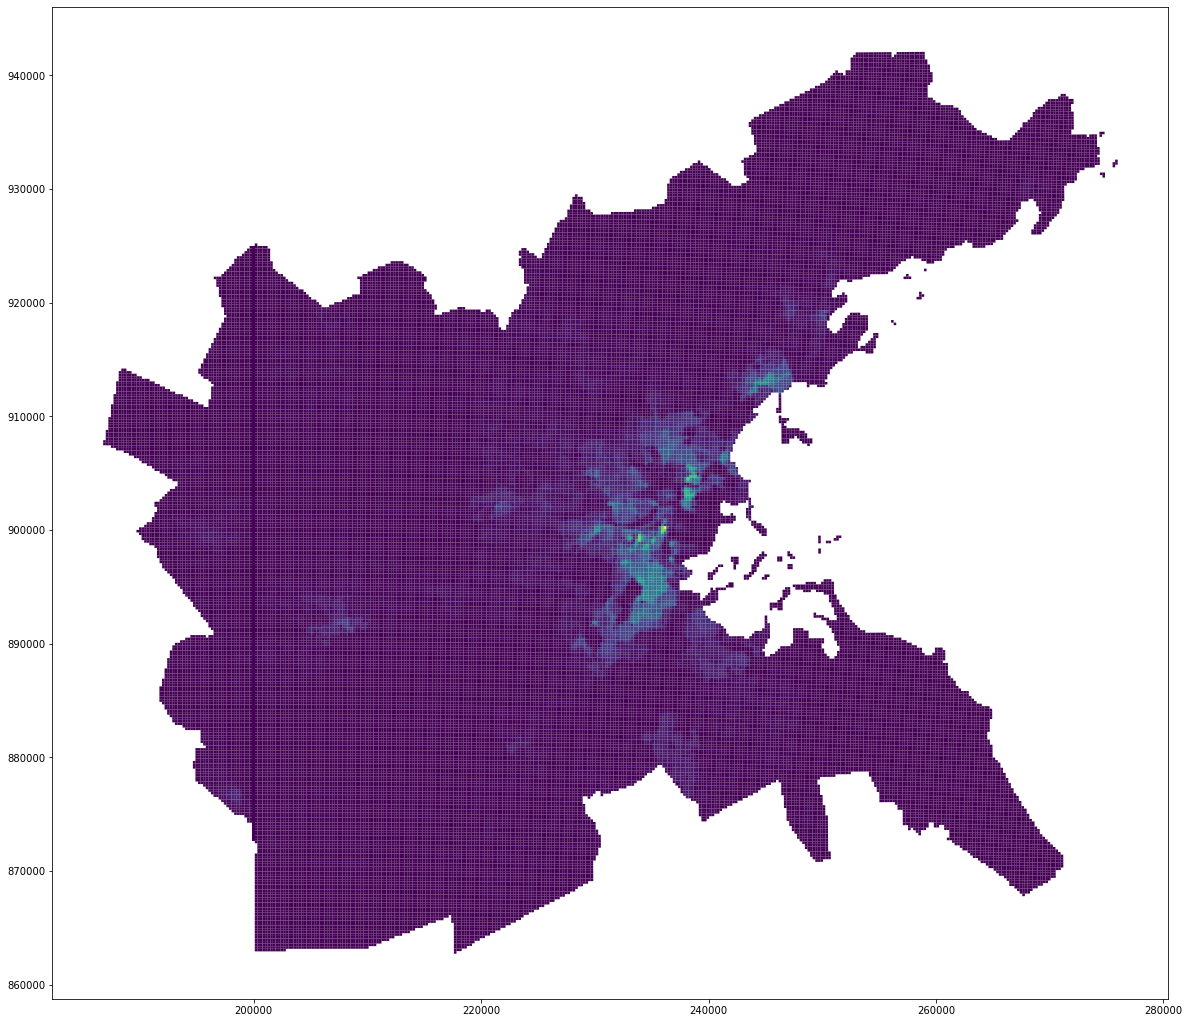

In [20]:
#dasy.columns
demo_cols = ['pop_dec_adult', 'pop_dec', 'hh_dec','minority_adult',
       'nonminority_adult', 'minority', 'nonminority', 'lowinc_adult',
       'nonlowinc_adult', 'lowinc', 'nonlowinc', 'zero_veh_hh',
       'non_zero_veh_hh']
dasy_dis[demo_cols] = dasy_dis[demo_cols].fillna(0)
interp = area_interpolate(dasy_dis, mpo_grid, extensive_variables=demo_cols)
#interp['plot'] = interp.pop_dec.apply(np.log1p)

fig, ax = plt.subplots(figsize=(20,20))
interp.plot('minority', ax=ax)

In [92]:
#interp

## Check sums and save output

In [21]:
print( 'pop_dec interpolated' , interp['pop_dec'].sum())
print( 'hh_dec interpolated' , interp['hh_dec'].sum())

pop_dec interpolated 3357193.9738893844
hh_dec interpolated 1315774.9910624232


In [22]:
interp.to_file("pop_output/dasy_demo.gpkg", layer = 'interpolated')
dasy_dis.to_file("pop_output/dasy_demo.gpkg", layer = 'dasy_clip')
dev_mpo.to_file("pop_output/dasy_demo.gpkg", layer = 'developed_mpo')